# Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

| Data Description |    |
|--------------------------|--------------------------------------------------------------------------------|
| city                   | city this user signed up in                                                    |
|  phone                  | primary device for this user                                                   |
|  signup_date            | date of account registration; in the form ‘YYYY MM DD’                         |
|  last_trip_date         | the last time this user completed a trip; in the form ‘YYYY MM DD’             |
|  avg_dist               | the average distance in miles per trip taken in the first 30 days after signup |
|  avg_rating_by_driver   | the rider’s average rating over all of their trips                             |
|  avg_rating_of_driver   | the rider’s average rating of their drivers over all of their trips            |
|  surge_pct              | the percent of trips taken with surge multiplier > 1                           |
|  avg_surge              | The average surge multiplier over all of this user’s trips                     |
|  trips_in_first_30_days | the number of trips this user took in the first 30 days after  signing up                |
|  ultimate_black_user    | TRUE if the user took an Ultimate Black in their first 30 days;FALSE otherwise |
|  weekday_pct            | the percent of the user’s trips occurring during a weekday                     |

In [100]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline
plt.style.use('ggplot')

### Loading up data

In [3]:
# pandas fails here
# df = pd.read_json('ultimate_data_challenge.json', orient='records')

In [108]:
# load json records (list of dictionaries)
with open('ultimate_data_challenge.json') as f:
    records = json.load(f)

In [109]:
# create dataframe
df = pd.DataFrame(records)

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [111]:
# modify data types for datetime
df.signup_date = pd.to_datetime(df.signup_date, format = '%Y-%m-%d')
df.last_trip_date = pd.to_datetime(df.last_trip_date, format = '%Y-%m-%d')

# same for category
df.phone = df.phone.astype('category')
df.city = df.city.astype('category')

### 1. Missing data: average ratings (rider and driver) as well as phone device

In [14]:
df.describe(include='all')

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000,50000,50000,50000,50000.000000,50000.000000,50000,50000.000000
unique,NaN,NaN,NaN,NaN,3,182,2,31,NaN,NaN,2,NaN
top,NaN,NaN,NaN,NaN,Winterfell,2014-06-29 00:00:00,iPhone,2014-01-18 00:00:00,NaN,NaN,False,NaN
freq,NaN,NaN,NaN,NaN,23336,2036,34978,2948,NaN,NaN,31146,NaN
first,NaN,NaN,NaN,NaN,NaN,2014-01-01 00:00:00,NaN,2014-01-01 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2014-07-01 00:00:00,NaN,2014-01-31 00:00:00,NaN,NaN,NaN,NaN
mean,5.796827,4.778158,4.601559,1.074764,NaN,NaN,NaN,NaN,8.849536,2.278200,NaN,60.926084
std,5.707357,0.446652,0.617338,0.222336,NaN,NaN,NaN,NaN,19.958811,3.792684,NaN,37.081503
min,0.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000
25%,2.420000,4.700000,4.300000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,33.300000


In [15]:
df.phone.value_counts()

iPhone     34978
Android    15022
Name: phone, dtype: int64

In [13]:
# replace phone by most frequent phone device
df.loc[df.phone.isnull(), 'phone'] = 'iPhone'

In [22]:
# replace average rating by median
df.loc[df.avg_rating_by_driver.isnull(), 'avg_rating_by_driver'] = df.avg_rating_by_driver.median()
df.loc[df.avg_rating_of_driver.isnull(), 'avg_rating_of_driver'] = df.avg_rating_of_driver.median()

### 1. EDA

Average ratings by driver are rarely under 4.5. However, there are outliers.

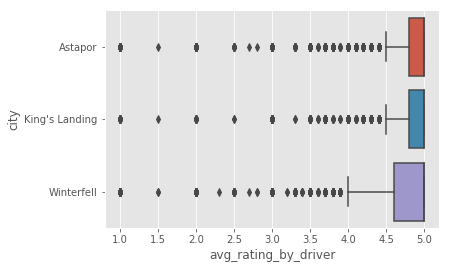

In [47]:
# plt.scatter(df.avg_rating_by_driver, df.avg_rating_of_driver)
sns.boxplot(x='avg_rating_by_driver', y='city', data = df)

Ratings of drivers tend to be a little lower. There are more outliers too.

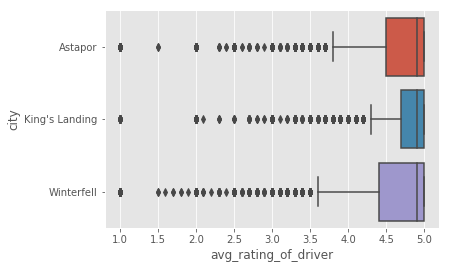

In [48]:
sns.boxplot(x='avg_rating_of_driver', y='city', data = df)

Riders from King's Landing who are using iphone tend to take more trip duting the first 30 days.

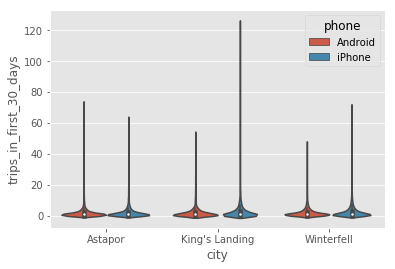

In [67]:
sns.violinplot(y = 'trips_in_first_30_days', x = 'city', hue = 'phone', data = df)

There is a wider distribution of number of trips in the first 30 days for riders who tried ultimate black.

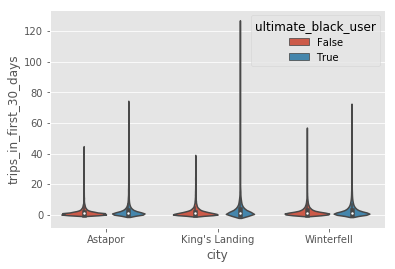

In [68]:
sns.violinplot(y = 'trips_in_first_30_days', x = 'city', hue = 'ultimate_black_user', data = df)

In [75]:
# sns.pairplot(df, vars=['avg_dist', 'trips_in_first_30_days'], hue='city')

In [74]:
# Percentage of riders retained
percent_retained = (df.last_trip_date > '2014-06-01').sum() / df.last_trip_date.count() * 100
print('Percent Retained: {:.2f}%'.format(percent_retained))

Percent Retained: 36.62%


In [63]:
# create target column
df['retained'] = df.last_trip_date > '2014-06-01'

### 2. Model Building

In [106]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained,city_King's Landing,city_Winterfell,phone_iPhone
0,3.67,5.0,4.7,1.10,15.4,4,True,46.2,True,1,0,1
1,8.26,5.0,5.0,1.00,0.0,0,False,50.0,False,0,0,0
2,0.77,5.0,4.3,1.00,0.0,3,False,100.0,False,0,0,1
3,2.36,4.9,4.6,1.14,20.0,9,True,80.0,True,1,0,1
4,3.13,4.9,4.4,1.19,11.8,14,False,82.4,False,0,1,0


In [107]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report
from sklearn.pipeline import Pipeline
# from imblearn.pipeline import Pipeline as imbPipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import EditedNearestNeighbours

In [81]:
# drop date columns
df = df.drop(labels=['signup_date', 'last_trip_date'], axis = 1)

In [82]:
# encode categories (city and phone)
df = pd.get_dummies(df, drop_first=True)

In [84]:
# get target values
y = df.retained.values
X = df.drop(labels='retained', axis = 1).values

# keep test set
X_train, X_test, y_train, y_test = \
            train_test_split( X , y, test_size = 0.2, random_state = 7, stratify = y)

In [93]:
log_clf = Pipeline([
                       ('scaler', MinMaxScaler()),
                       ('clf', LogisticRegression(random_state=7, class_weight='balanced')),
                    ])

# paramter grid search
parameters = [
              {
              'clf__C': [0.1, 0.3, 1],
              }
            ]

# set up grid search
gs_clf = GridSearchCV(log_clf, param_grid = parameters, cv = 5 , scoring='roc_auc' , n_jobs = -1, verbose = 3)

In [94]:
# perform grid search CV on pipeline
_ = gs_clf.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:    2.0s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    2.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.0s finished
c:\programdata\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [95]:
gs_clf.best_params_

{'clf__C': 1}

In [96]:
# show classification report
y_train_pred = gs_clf.predict(X_train)
print(classification_report(y_train, y_train_pred, target_names=["not active", "active"]))

             precision    recall  f1-score   support

 not active       0.79      0.72      0.76     25352
     active       0.58      0.67      0.62     14648

avg / total       0.72      0.70      0.71     40000



In [97]:
# show classification report
y_pred = gs_clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["not active", "active"]))

             precision    recall  f1-score   support

 not active       0.80      0.73      0.76      6338
     active       0.59      0.69      0.64      3662

avg / total       0.72      0.71      0.72     10000



Our model is most likely too simple as train and test score are roughly the same. Our regularization constant is minimal too which is consistent.

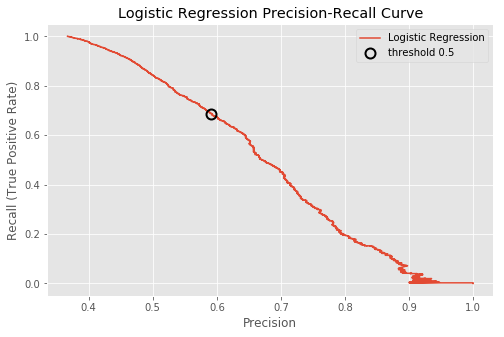

In [102]:
y_pred_prob = gs_clf.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
close_zero = np.argmin(np.abs(thresholds-0.5))

_ , axpr = plt.subplots(figsize = (8, 5))
# plot precision-recall
axpr.plot(precision, recall, label='Logistic Regression')
axpr.set_xlabel('Precision')
axpr.set_ylabel('Recall (True Positive Rate)')
axpr.set_title('Logistic Regression Precision-Recall Curve')
# plot zero threshold
axpr.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold 0.5", fillstyle="none", c='k', mew=2)
# mew: markeredgewidth
_ = plt.legend()

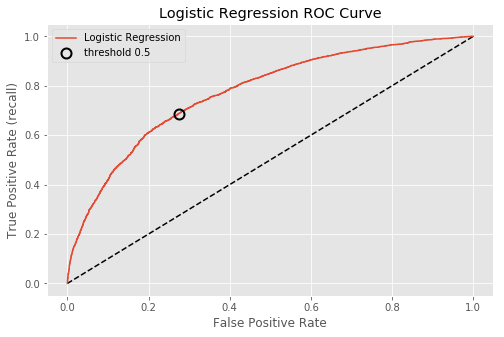

In [105]:
# ROC_AUC is not ideal for class imbalance as it doesn't focus on the minority class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
close_zero = np.argmin(np.abs(thresholds-0.5))

_ , axroc = plt.subplots(figsize = (8, 5))
# diagonal
axroc.plot([0, 1], [0, 1], 'k--')
# plot ROC
axroc.plot(fpr, tpr, label='Logistic Regression')
axroc.set_xlabel('False Positive Rate')
axroc.set_ylabel('True Positive Rate (recall)')
axroc.set_title('Logistic Regression ROC Curve')
# plot zero threshold
axroc.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold 0.5", fillstyle="none", c='k', mew=2)
_ = plt.legend()

### 3. Insights

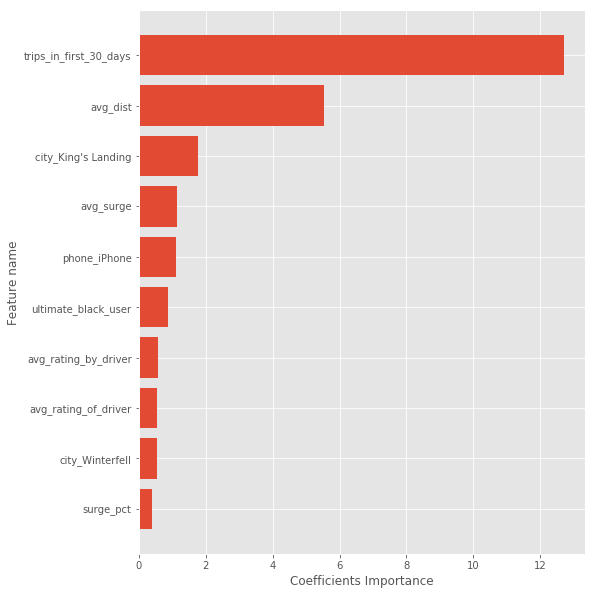

In [104]:
# get column names except target
names = df.drop(labels='retained', axis = 1).columns

# get coefficient of logistic regression model
log_coef = gs_clf.best_estimator_.named_steps['clf'].coef_
# flatten it
log_coef = np.abs(log_coef.ravel())
# get indices for sorting in descending order
indsorted = log_coef.argsort()[::-1]
# apply indices to names and coeff
names = names[indsorted[:10]]
log_coef = log_coef[indsorted[:10]]
y_pos = range(len(names))

# make plot
figimp , aximp = plt.subplots(figsize = (8, 10))
aximp.barh(y_pos, log_coef)
aximp.set_yticks(y_pos)
aximp.set_yticklabels(names)
aximp.set_ylabel('Feature name')
aximp.set_xlabel('Coefficients Importance')
aximp.invert_yaxis()

The number of trips taken during the first 30 days is the most predictive feature.